<a href="https://colab.research.google.com/github/helinlee2010/Dog_Breed_Identifier/blob/master/dog_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐶 End-to-end Multil-class Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem
Identifying the breed of a dog given an image of a dog.

When I'm sitting at the cafe and I take a photo of a dog, I want to know what breed of dog it is.

## 2. Data
The data we're using is from Kaggle's dog breed identification competition.

https://www.kaggle.com/c/dog-breed-identification/data

## 3. Evaluation
The evaluation is a file with prediction probabilities for each dog breed of each test image.

https://www.kaggle.com/c/dog-breed-identification/overview/evaluation

## 4. Features
Some information about the data:

* We're dealing with images (unstructured data) so it's probably best we use deep learning/transfer learning.
* There are 120 breeds of dogs (this means there are 120 different classes).
* There are around 10,000+ images in the training set (these images have labels).
* There are around 10,000+ images in the test set (these images have no labels, because we'll want to predict them).

### Get our workspace ready
* Import TensorFlow 2.x ✅
* Import TensorFlow Hub ✅
* Make sure we're using GPU ✅

In [ ]:
# Unzip the uploaded data into google drive

# !unzip "drive/My Drive/MachineLearning Data/Dog vision/dog-breed-identification.zip" -d "drive/My Drive/MachineLearning Data/Dog vision/"

#### Import necessary tools

In [ ]:
# Import TensorFlow into Colab

import tensorflow as tf
import tensorflow_hub as hub
print("TensorFlow version:", tf.__version__ )
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "Available" if tf.config.list_physical_devices("GPU") else "not available :(")

TensorFlow version: 2.2.0-rc3
TF Hub version: 0.8.0
GPU Available


## Get our data reday (Turn into Tensors)

With all machine learning models, our data has to be in numerical format. So that's what we'll be doing first: 
* Turning our images into Tensors (numerical representations, like matrix).

Let's start by accessing our data and checking out the labels.

In [ ]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/MachineLearning Data/Dog vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     b1e8dfb27a65a838de14079947684fb8  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

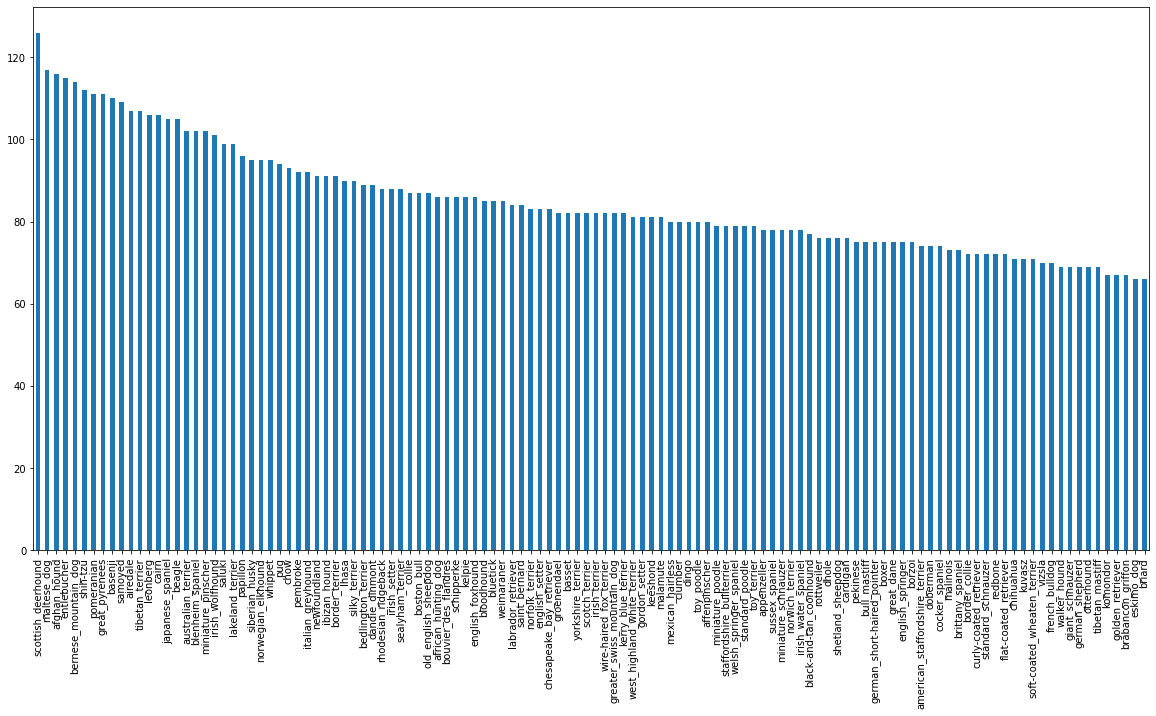

In [ ]:
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
# What's the median number of images per class?
labels_csv["breed"].value_counts().median()

82.0

In [ ]:
labels_csv["breed"].value_counts().min()

66

According to https://cloud.google.com/vision/automl/docs/prepare
Google recommends to have about 1000 training images per label, or at least 10 per label for trainning.

In [ ]:
# Let's view an image

# from IPython.display import Image
# Image("drive/My Drive/MachineLearning Data/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg")

### Get images & their labels

Let's get a list of all our image file  pathnames.

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# Create a list of pathnames from image ID
# a list so that we can compare length later
pathnames = ["drive/My Drive/MachineLearning Data/Dog vision/train/" + idName + ".jpg" for idName in labels_csv["id"]]

# Check the first 10
pathnames[:10]

['drive/My Drive/MachineLearning Data/Dog vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/MachineLearning Data/Dog vision/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [ ]:
import os
os.listdir("drive/My Drive/MachineLearning Data/Dog vision/train/")[:10]

['f591763666758b806f71459819ce8602.jpg',
 'f6575543e0456836d1fc6871e586a6e0.jpg',
 'ea906db2c833f5140b009eabba209eaa.jpg',
 'ee4f333b5dbfab72ccd4225f81920e8f.jpg',
 'ec1654e55864cef34ec43800744f8ac2.jpg',
 'f056299c0c659aa73947f76837369a9f.jpg',
 'f312a698c57b976f011a6d54607e81b7.jpg',
 'f2b5ba1f32494b942731fb5248e114a8.jpg',
 'ea607b36bd3391a5b4fe4c547f5dd7c7.jpg',
 'f06d9112ed14edb4038daa54f1b1abd5.jpg']

In [ ]:
# Check whether number of filenames matches number of actual image files

if len(os.listdir("drive/My Drive/MachineLearning Data/Dog vision/train/")) == len(pathnames):
  print("Amount of pathnames matches amount of files in the dir!! Proceed. ")
else:
  print("Filenames do no match actual amount of files, check the target directory")

Amount of pathnames matches amount of files in the dir!! Proceed. 


In [ ]:
# One more check
# Image(pathnames[600])

In [ ]:
labels_csv["breed"][600]

'tibetan_terrier'

Since we've now got our training image filepaths in a list, let's prepare our labels

In [ ]:
import numpy as np

labels = labels_csv["breed"].to_numpy() #same as below
# labels = np.array(labels_csv["breed"])

labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
# See if number of labels matches the number of pathnames

if len(labels) == len(pathnames):
  print("Number of labels matches number of pathnames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")


Number of labels matches number of pathnames!


In [ ]:
# Find the unique values in labels

unique_breeds = np.unique(labels)
unique_breeds

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale',
       'american_staffordshire_terrier', 'appenzeller',
       'australian_terrier', 'basenji', 'basset', 'beagle',
       'bedlington_terrier', 'bernese_mountain_dog',
       'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound',
       'bluetick', 'border_collie', 'border_terrier', 'borzoi',
       'boston_bull', 'bouvier_des_flandres', 'boxer',
       'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff',
       'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua',
       'chow', 'clumber', 'cocker_spaniel', 'collie',
       'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo',
       'doberman', 'english_foxhound', 'english_setter',
       'english_springer', 'entlebucher', 'eskimo_dog',
       'flat-coated_retriever', 'french_bulldog', 'german_shepherd',
       'german_short-haired_pointer', 'giant_schnauzer',
       'golden_retriever', 'gordon_setter', 'great_dane',
      

In [ ]:
len(unique_breeds)

120

In [ ]:
# Turn a single label into an array of booleans
print(labels[0])   # First item's breed type
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [ ]:
# Scale up:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]

# Preview
boolean_labels[:3]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

The length in boolean_labels should be equal to the length of labels

In [ ]:
len(labels), len(boolean_labels)

(10222, 10222)

In [ ]:
# Turn boolean array into integers
# as an example, we'll use the first label

print(labels[0])
# Show the Index where labels occur in unique_breeds
print(np.where(labels[0] == unique_breeds))
# Index where label occurs in boolean array
print(boolean_labels[0].argmax())

print(boolean_labels[0].astype(int))
# There'll be a 1 where sample label(breed) occurs in unique_breeds

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
# Example: Test for another label
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Create our own validation set

Since the dataset from Kaggle doesn't come with a validation set, we're going to create our own.

In [ ]:
# Setup X & y
X = pathnames
y = boolean_labels

We're going to start off experimenting with ~1000 images and increase as needed.

In [ ]:
# Set number of images to use for experimenting

# Capital because we're defining cutomized parameter
NUM_IMAGES = 1000 #@param{type:"slider", min:1000, max:10000, step:1000}

In [ ]:
# Split data into train & validation sets
from sklearn.model_selection import train_test_split

# Split them from total size: NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

# Check the length/shape of training & validation data before moving further, important!!
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

In [ ]:
# Have a geez at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/MachineLearning Data/Dog vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/MachineLearning Data/Dog vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/MachineLearning Data/Dog vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/MachineLearning Data/Dog vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/MachineLearning Data/Dog vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, Fals

## Preprocessing Images (Turn images into Tensors)

To do this, we need to write a function to do few things:

1. Take an image filepath as inpur
2. Use TensoFlow to read to file & Save it to a variable - image
3. Turn our image (jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224,224)
6. Return the modified image

Before doing, check what importing an image looks like:

In [ ]:
# Convert image to Numpy array
from matplotlib.pyplot import imread
image = imread(pathnames[42])
image.shape

(257, 350, 3)

In [ ]:
image

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  53],
        [ 97,  88,  49],
        [120, 111,  72]]

These values are in the range of 0 - 255 which a is RGB value
- Each pixel in an image is a combination of R,G,B color --> RGB value

In [ ]:
image.max(), image.min()

(255, 0)

In [ ]:
# Turn the image(np array) to a Tensor
tf.constant(image)

<tf.Tensor: shape=(257, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]],

       [[ 56, 104,  66],
        [ 58, 106,  66],
        [ 64, 112,  72],
        ...,
        [ 71, 127,  82],
        [ 73, 129,  84],
        [ 73, 130,  85]],

       ...,

       [[  2,  11,  10],
        [  5,  14,  13],
        [  6,  15,  14],
        ...,
        [120, 113,  67],
        [126, 118,  72],
        [122, 114,  67]],

       [[  0,   4,   6],
        [  0,   9,   8],
        [  1,  10,   9],
        ...,
        [105,  98,  52],
        [111, 104,  58],
        [111, 103,  56]],

       [[ 18,  16,  37],
        [ 18,  18,  28],
        [ 17,  20,  11],
        ...,
        [101,  92,  5

In [ ]:
image[:2]

array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)

In [ ]:
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

Now we've seen what an image looks like as a Tensor, let's make a function to preprocess them.

We'll create a function to:

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, image
3. Turn our image (a jpg) into Tensors
4. Normalize our image (convert color channel values from from 0-255 to 0-1).
5. Resize the image to be a shape of (224, 224)
6. Return the modified image

More information on loading images in TensorFlow can be seen here: https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images

def process_image(image_path, img_size = IMG_SIZE):
  """
  Takes an image file path & Turns it into a Tensor.
  """

  # Read an image file, return a string Tensor
  image = tf.io.read_file(image_path)
  # Decode a read jpeg image(actually a string tensor)
  # with 3 color channels(R,G,B), turn into numerical tensor
  image = tf.image.decode_jpeg(image, channels=3)
  # Normalization: convert color channel values from 0-255 to 0-1(float)
  # Scaling down for efficiency
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [ ]:
tf.io.read_file(pathnames[0])

<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\n\x07\x07\x08\x07\x06\n\x08\x08\x08\x0b\n\n\x0b\x0e\x18\x10\x0e\r\r\x0e\x1d\x15\x16\x11\x18#\x1f%$"\x1f"!&+7/&)4)!"0A149;>>>%.DIC<H7=>;\xff\xdb\x00C\x01\n\x0b\x0b\x0e\r\x0e\x1c\x10\x10\x1c;("(;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;;\xff\xc0\x00\x11\x08\x01w\x01\xf4\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1f\x00\x00\x01\x05\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\x07\x08\t\n\x0b\xff\xc4\x00\xb5\x10\x00\x02\x01\x03\x03\x02\x04\x03\x05\x05\x04\x04\x00\x00\x01}\x01\x02\x03\x00\x04\x11\x05\x12!1A\x06\x13Qa\x07"q\x142\x81\x91\xa1\x08#B\xb1\xc1\x15R\xd1\xf0$3br\x82\t\n\x16\x17\x18\x19\x1a%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxyz\x83\x84\x85\x86\x87\x88\x89\x8a\x92\x93\x94\x95\x96\x97\x98\x99\x9a\xa2\xa3\xa4\xa5\xa6\xa7\xa8\xa9\xaa\xb2\xb3\xb4\xb5\xb6\xb7\xb8\xb9\xba\xc2\xc3\xc4\xc5\xc6\xc7\xc8\xc9\xca

In [ ]:
tf.image.decode_jpeg(pathnames[0], channels=3)

InvalidArgumentError: ignored

## Turning our data into batches
Why do so?

If you're trying to process 10,000+ images in one go, they all might not fit into memory.

So we do about 32 (this is the batch size) images at a time (you can manually adjust the batch size).

- In order to use TensorFlow effectively, we need our data in the form of Tensor tuples which look like this: (image, label).


In [ ]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path name & the associated label, processes the image and 
  returns a type of (image, label).
  """

  image = process_image(image_path)
  return image, label

In [ ]:
# Demo of above
(process_image(X[42]), tf.constant(y[42]))
# X is filepath as a string, y is a boolean array with only 1 True

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [ ]:
get_image_label(X[42],y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048


Now we've got a way to turn our data into tuples of Tensors in the form: (image, label), let's make a function to turn all of our data (X & y) into batches!

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False,
                        test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  # If it's a test dataset, it won't have label
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    #only filepaths (no labels)

    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If it's a valid. dataset, no need to shuffle 
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), #filepaths
                                               tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE) # tuple
    return data_batch

  # Traning
  else:
    print("Creating training data batches...")
    # Turn filepaths & labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffle pathnames & labels before mapping image processor fxn is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image,label) tuples (this also turns the img path into a preprocessed img)
    data = data.map(get_image_label)
    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch
  

In [ ]:
# Create Training & Validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec
# X,y

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

Our data is now in batches, however, these can be hard to understand...
Let's visualize them!

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch

def show_25_images(images, labels):
  """
  Display a plot of 25 images and their labels from a 
  data batch.
  """

  # Setup the figure
  plt.figure(figsize=(10,10))
  # Loop through 25 (to display 25 images)
  for i in range(25):
    # Create subplots with 5 row, 5 cols, index
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #labels are lists of boolean arrays

    # Turn the grid lines off
    plt.axis("off")


In [ ]:
train_data #None indicates the cutomized batch size

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

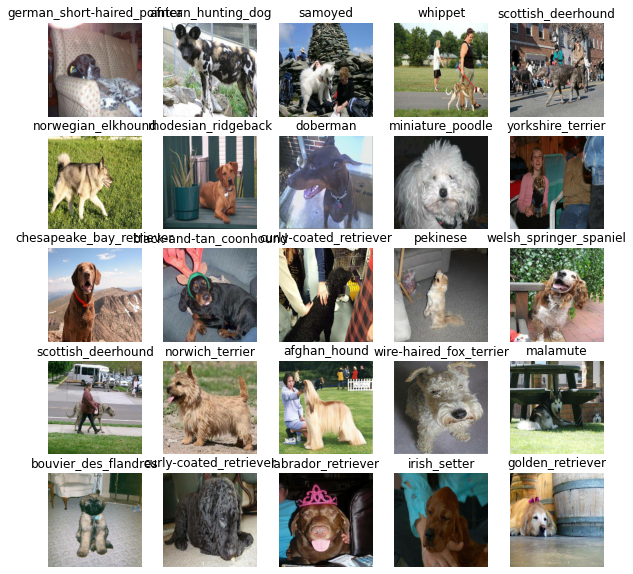

In [ ]:
# Visualize the data in the training batch

# unbatch?
# train_images, train_labels = next(train_data.as_numpy_iterator())

# show_25_images(train_images, train_labels)

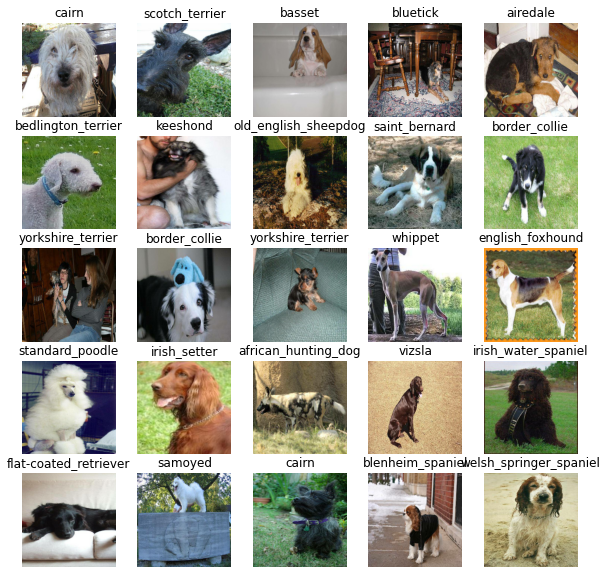

In [ ]:
# Visualize the validation data set

# val_images, val_labels = next(val_data.as_numpy_iterator())
# show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:

- The input shape (our images shape, in the form of Tensors) to our model.
- The output shape (image labels, in the form of Tensors) of our model.
- The URL of the model we want to use from TensorFlow Hub - https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification

In [ ]:
IMG_SIZE

224

In [ ]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3]
# batch, height, width, colour channels
# check this by run either: val_data, train_data 

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"


In [ ]:
INPUT_SHAPE

[None, 224, 224, 3]

Now we've got our inputs, outputs and model ready to go. Let's put them together into a Keras deep learning model!

Knowing this, let's create a function which:

- Takes the input shape, output shape and the model we've chosen as parameters.
- Defines the layers in a Keras model in sequential fashion (do this first, then this, then that).
- Compiles the model (says it should be evaluated and improved).
- Builds the model (tells the model the input shape it'll be getting).
Returns the model.

All of these steps can be found here: https://www.tensorflow.org/guide/keras/overview

In [ ]:
# Create a function which builds a Keras model

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE,
                 model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers, instantiate a model
  # ([Layer 1/ input, Layer 2/ output])
  # activation for multiclass model is: Softmax
  model = tf.keras.Sequential([
    hub.KerasLayer(MODEL_URL), # Input Layer                         
    tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax")])
  
  # Compile the model (loss is lower the better)
  # "Down the hill"
  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model


In [ ]:
# model = create_model()
# model.summary()

## Creating Callbacks
Callbacks are helper functions a model can use during training to do such things as save its progress, check its progress or stop training early if a model stops improving.

We'll create two callbacks, one for TensorBoard which helps track our models progress and another for early stopping which prevents our model from training for too long.

### TensorBoard Callback
To setup a TensorBoard callback, we need to do 3 things:

1. Load the TensorBoard notebook extension ✅
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's fit() function. ✅
3. Visualize our models training logs with the %tensorboard magic function (we'll do this after model training).

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard



In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import  datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/MachineLearning Data/Dog vision/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback
Early stopping helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [ ]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Train a model (on a subset of data)

Our first model is only going to train on 1000 iamges, to make sure everything is working.

In [ ]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [ ]:
# Check to make sure we're still running on a GPU
print("GPU", "available" if tf.config.list_physical_devices("GPU")
else "not availabel :(")

GPU available



Let's create a function which trains a model.

- Create a model using `create_model()`
- Setup a TensorBoard callback using `create_tensorboard_callback()`
- Call the `fit()` function on our model passing it the training data, validation data, number of epochs to train for `(NUM_EPOCHS)` and the callbacks we'd like to use
-Return the model